In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import pandas as pd
import joblib
# from mprompt.config import RESULTS_DIR
import torch.cuda
import json
from sklearn.linear_model import RidgeCV
import pandas as pd
import re
import pyLDAvis
import pyLDAvis.lda_model
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import adjustText
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
import os
from os.path import join
from tqdm import tqdm
from InstructorEmbedding import INSTRUCTOR

RESULTS_DIR = '/home/chansingh/mprompt/results'
# df = pd.read_csv(join(RESULTS_DIR, 'bert', "dict_learn_results - extracted factors_all.csv"))
expls_scores_bert = joblib.load(join(RESULTS_DIR, 'bert', 'wiki_norm_std', 'wiki_our_syn_perc_std_score.pkl'))

# BERT_RAW_RESULTS_DIR = '/home/chansingh/mntv1/aliyah/ah-module-prompt/results/'
# for layer in tqdm(range(13)):
#     layer_dir = f'dl_l{layer}'
#     for factor in range(1500):
#         factor_dir = f'i{factor}'
#         extra_dir = os.listdir(join(BERT_RAW_RESULTS_DIR, layer_dir, factor_dir))[0]
#         results = joblib.load(join(BERT_RAW_RESULTS_DIR, layer_dir, factor_dir, extra_dir, 'results.pkl'))
#         expl = results['top_explanation_init_strs']
#         expls.append(expl)
# joblib.dump(join(RESULTS_DIR, 'bert', 'expls_bert.jbl'))
expls_bert = joblib.load(join(RESULTS_DIR, 'bert', 'expls_bert.jbl'))


df_f = pd.read_pickle(join(RESULTS_DIR, 'results_fmri_full.pkl'))
expls_fmri = df_f['top_explanation_init_strs'].values.tolist()

df_bert = pd.DataFrame.from_dict({
    'layer': sum([[i] * 1500 for i in range(13)], []),
    'score': expls_scores_bert.flatten(),
    'expl': expls_bert,
})
df_fmri = pd.DataFrame.from_dict({
    'layer': 'fmri',
    'score': df_f['top_score_synthetic'].values,
    'expl': expls_fmri,
})

# filter dfs
df_bert = df_bert[df_bert['score'] > 1]
df_fmri = df_fmri[df_fmri['score'] > 0]
n_bert = len(df_bert)
expls = df_bert['expl'].values.tolist() + df_fmri['expl'].values.tolist()

# tSNE Embeddings Viz

In [21]:
# get embeddings
embeddor = INSTRUCTOR('hkunlp/instructor-xl')
instruction = "Represent the short phrase for clustering:"
embs = embeddor.encode([[instruction, x_i] for x_i in expls], batch_size=32)
tsne = TSNE(n_components=2, random_state=42, verbose=False)
word_vectors_2d = tsne.fit_transform(embs)
df_bert['x'] = word_vectors_2d[:, 0][:n_bert]
df_bert['y'] = word_vectors_2d[:, 1][:n_bert]
df_fmri['x'] = word_vectors_2d[:, 0][n_bert:]
df_fmri['y'] = word_vectors_2d[:, 1][n_bert:]

load INSTRUCTOR_Transformer
max_seq_length  512


adjusting texts...


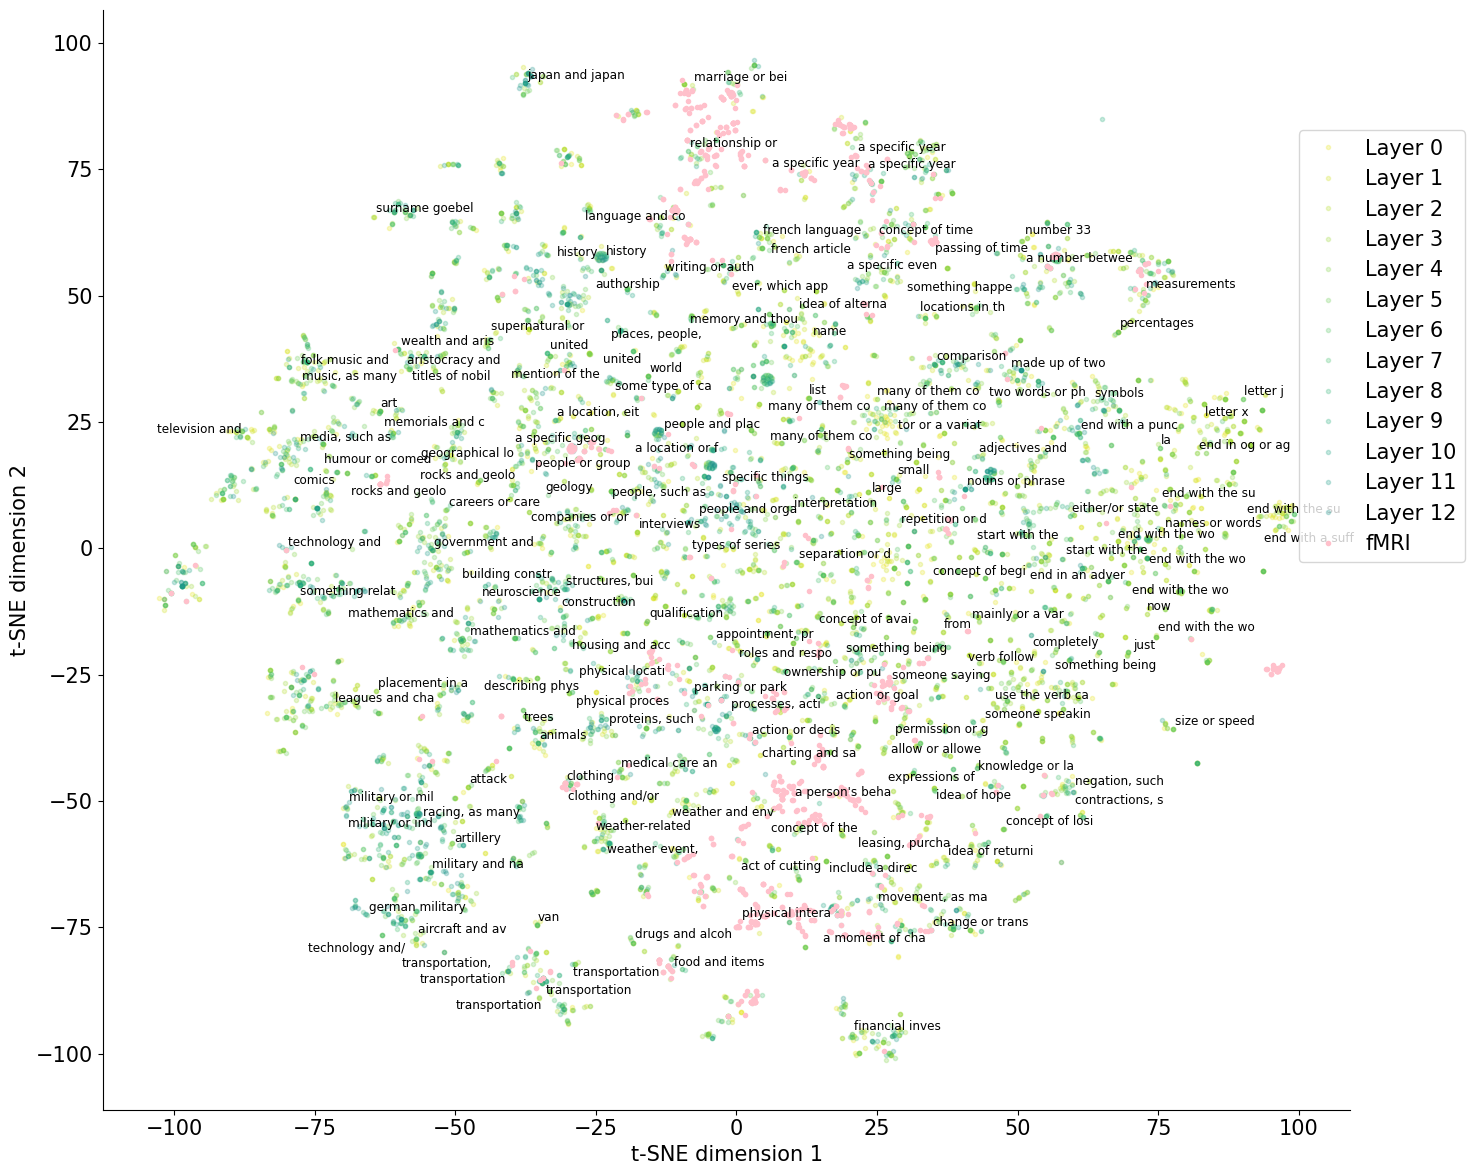

In [27]:
def plot_tsne(df_bert, df_fmri, hue='layer', label_map_dict=None, adjust_text=True):
    for lay in sorted(df_bert[hue].unique()):
        df_plot_lay = df_bert[df_bert[hue] == lay]
        if hue == 'layer':
            label = f"Layer {lay}"
        elif hue == 'topic_num':
            label = label_map_dict[lay]
        plt.plot(
            df_plot_lay['x'],
            df_plot_lay['y'],
            marker=".",
            alpha=0.25,
            # markersize=1,
            label=label,
            color=sns.color_palette("viridis_r", 26)[lay],
            linestyle="None",
        )

    plt.plot(
            df_fmri['x'],
            df_fmri['y'],
            marker=".",
            alpha=1,
            # markersize=1,
            label=f"fMRI",
            color='pink',
            linestyle="None",
        )
    texts = []
    for i, word in enumerate(df_bert['expl']):
        if i % 50 == 0:
            texts.append(
                plt.annotate(word[:15], (word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize='xx-small'))
    for i, word in enumerate(df_fmri['expl']):
        if i % 50 == 0:
            texts.append(
                plt.annotate(word[:15], (word_vectors_2d[n_bert + i, 0], word_vectors_2d[n_bert + i, 1]), fontsize='xx-small'))

    # make texts not overlap
    if adjust_text:
        print('adjusting texts...')
        adjustText.adjust_text(texts) #, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    

plt.figure(figsize=(15, 12))
plot_tsne(df_bert, df_fmri, adjust_text=True)
plt.legend(bbox_to_anchor=(1.1, 0.9))
plt.savefig(join(RESULTS_DIR, 'bert', 'tsne_unrestricted.png'), dpi=300, bbox_inches='tight')

# LDAVis

In [9]:
# Preprocessing: remove numbers, special characters, and lowercase all words
processed_docs = [re.sub(r"[^\w\s]", "", doc.lower()) for doc in expls]

# Add custom stop words
# additional_stop_words = ['dont', 'doesnt', 'didnt', 'couldnt', 'wont', 'cant']
# stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words="english", max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(processed_docs)
dtm_bert = dtm[:n_bert]

# LDA model - only fitting to BERT!!!
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Visualize clusters using PyLDAVis
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
# pyLDAvis.save_html(vis, join(RESULTS_DIR, 'bert', 'lda.html'))

# add topics to df
words = vectorizer.get_feature_names_out()
topic_names_dict = {
    topic_idx: f"{topic_idx + 1}: "
    + ", ".join([words[i] for i in topic.argsort()[:-8:-1]])
    for topic_idx, topic in enumerate(lda.components_)
}
print(topic_names_dict)
topics = lda.transform(dtm).argmax(axis=1)
df_bert["topic_num"] = topics[:n_bert]
df_fmri["topic_num"] = topics[n_bert:]

{0: '1: verb, form, military, specifically, measurements, naval, architecture', 1: '2: technology, related, music, andor, education, activities, science', 2: '3: people, places, things, names, end, military, letter', 3: '4: action, movement, relationships, physical, communication, family, idea', 4: '5: time, dates, preposition, different, mathematics, past, type', 5: '6: sports, physical, activity, locations, media, objects, action', 6: '7: word, end, contain, followed, number, phrase, noun', 7: '8: history, culture, concept, numbers, way, language, nouns', 8: '9: words, time, phrases, location, specific, movement, period', 9: '10: specific, type, year, place, person, government, particular'}


### Barplot

/tmp/ipykernel_2174261/2506378069.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.png'), dpi=300, bbox_inches='tight')
/tmp/ipykernel_2174261/2506378069.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.pdf'), dpi=300, bbox_inches='tight')
/tmp/ipykernel_2174261/2506378069.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.pdf'), dpi=300, bbox_inches='tight')
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommo

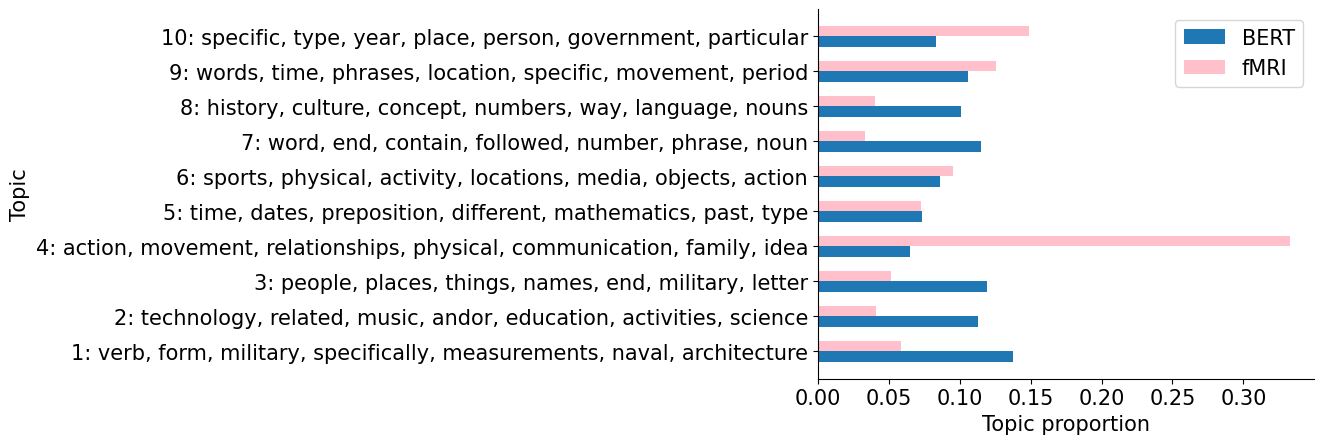

In [10]:
counts = pd.merge(
    (df_bert['topic_num'].value_counts() / len(df_bert)).reset_index(),
    (df_fmri['topic_num'].value_counts() / len(df_fmri)).reset_index(),
    on='topic_num',
).rename(columns={'count_x': 'bert', 'count_y': 'fmri'})

# make barplot from counts df with 'bert' and 'fmri' as the legend and topic_num as the ylabel
plt.barh(counts['topic_num'] - 0.15, counts['bert'], color ='C0', label='BERT', height=0.3)
plt.barh(counts['topic_num'] + 0.15, counts['fmri'], color='pink', label='fMRI', height=0.3)
plt.yticks(counts['topic_num'], labels=counts['topic_num'].map(topic_names_dict))
plt.xlabel('Topic proportion')
plt.ylabel('Topic')
plt.legend()
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.png'), dpi=300, bbox_inches='tight')
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.pdf'), dpi=300, bbox_inches='tight')

### Barplot by layer

In [11]:
df_bert

,layer,score,expl,topic_num
0,0,7.796899,drugs and alcohol,6
1,0,5.592463,nouns,7
2,0,7.985801,"concept of the mind, either in terms of consci...",7
6,0,2.208026,verb meet,0
8,0,15.633108,"titles of nobility, such as earl, viscount, ma...",5
...,...,...,...,...
19477,12,5.688376,japan in some way,7
19478,12,1.548167,"military terminology, specifically related to ...",1
19479,12,1.312441,places and people,2
19490,12,1.398191,"media or entertainment, such as music, sports,...",5


In [ ]:
for layer_idx in 

In [ ]:
counts = pd.merge(
    (df_bert['topic_num'].value_counts() / len(df_bert)).reset_index(),
    (df_fmri['topic_num'].value_counts() / len(df_fmri)).reset_index(),
    on='topic_num',
).rename(columns={'count_x': 'bert', 'count_y': 'fmri'})

# make barplot from counts df with 'bert' and 'fmri' as the legend and topic_num as the ylabel
plt.barh(counts['topic_num'] - 0.15, counts['bert'], color ='C0', label='BERT', height=0.3)
plt.barh(counts['topic_num'] + 0.15, counts['fmri'], color='pink', label='fMRI', height=0.3)
plt.yticks(counts['topic_num'], labels=counts['topic_num'].map(topic_names_dict))
plt.xlabel('Topic proportion')
plt.ylabel('Topic')
plt.legend()
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.png'), dpi=300, bbox_inches='tight')
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.pdf'), dpi=300, bbox_inches='tight')

### Boxplot

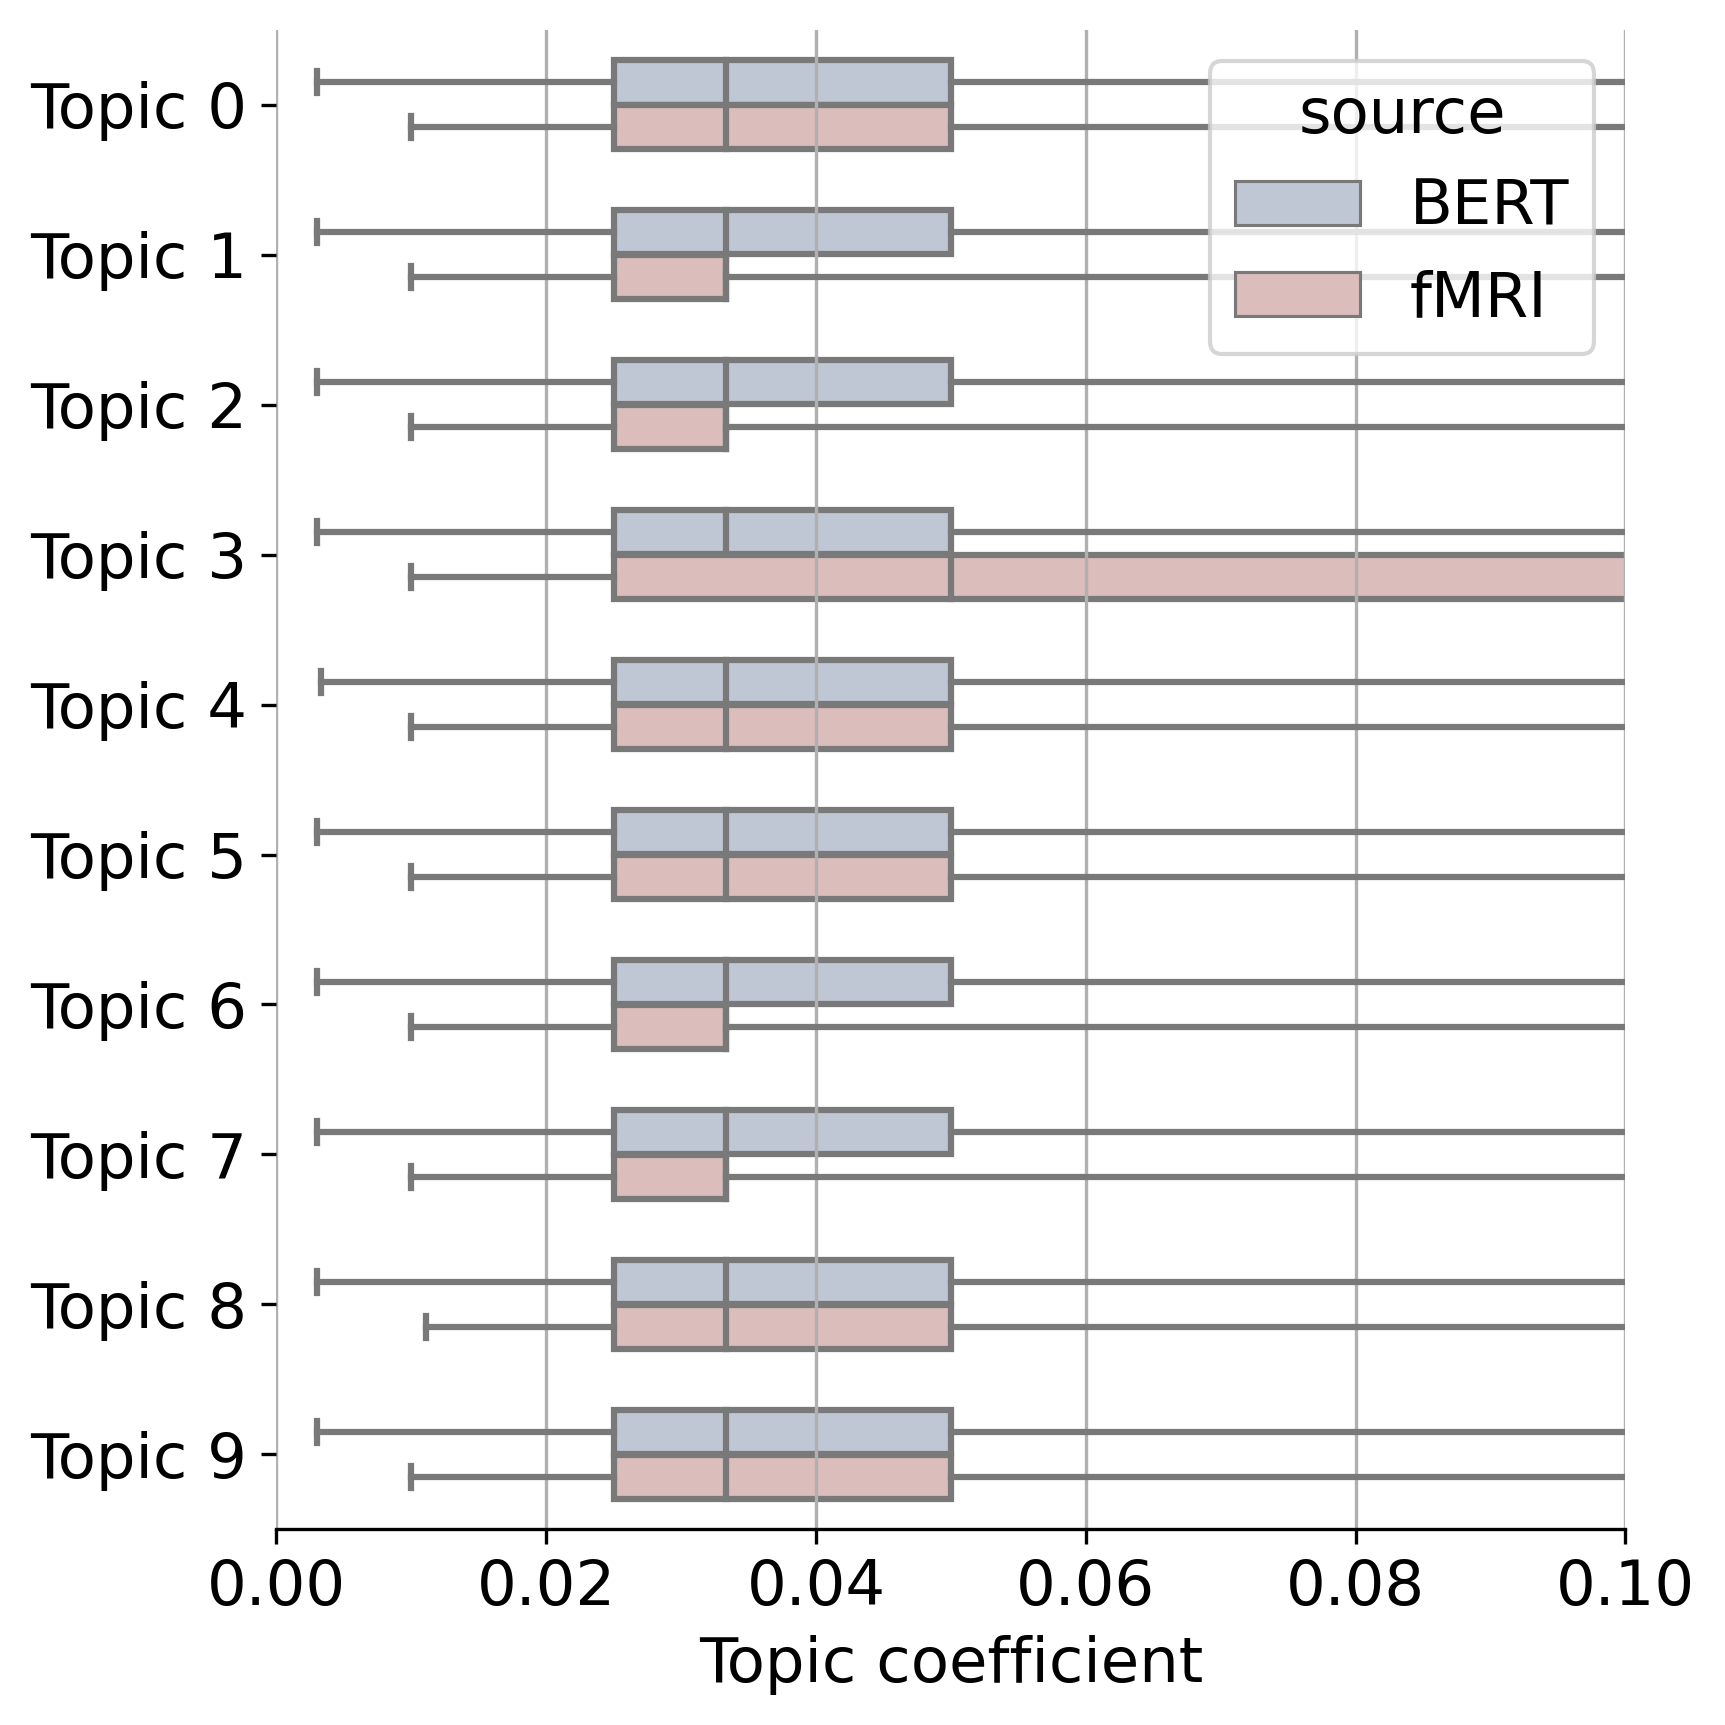

In [26]:
coefs = lda.transform(dtm)
coefs_bert = coefs[:n_bert].T
coefs_fmri = coefs[n_bert:].T

# sns.set_theme(style="ticks")
df_bert_box = pd.DataFrame.from_dict({
    'topic': sum([[f'Topic {i}'] * coefs_bert.shape[1] for i in range(coefs_bert.shape[0])], []),
    'coef': coefs_bert.flatten(),
    'source': 'BERT',
})
df_fmri_box = pd.DataFrame.from_dict({
    'topic': sum([[f'Topic {i}'] * coefs_fmri.shape[1] for i in range(coefs_fmri.shape[0])], []),
    'coef': coefs_fmri.flatten(),
    'source': 'fMRI',
})
df_box = pd.concat([df_bert_box, df_fmri_box])
# df = df_bert
f, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.boxplot(x="coef", y="topic", data=df_box,
            width=.6, palette="vlag", whis=[0, 100], hue='source')
# , whis=0, fliersize=0)
plt.xlim(0, 0.1)

# Add in points to show each observation
# sns.stripplot(x="coef", y="topic", data=df,
            #   size=2, color=".5", linewidth=0, alpha=0.1, hue='source',)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.xlabel("Topic coefficient")
plt.show()
# plt.savefig(join(RESULTS_DIR, 'bert', 'wiki_normalized_syn_scores', 'wiki_our_syn_perc_score_boxplot.png'))

In [ ]:
plt.figure(figsize=(20, 12))
plot_tsne(
    df_bert,
    df_fmri,
    hue="topic_num",
    label_map_dict=topic_names_dict,
    adjust_text=False,
)
plt.legend(bbox_to_anchor=(1.1, 0.9), fontsize='xx-small')